The purpose of this Python script is to intrepret a BED graph and generate plots of genome coverage, and specific gene coverage. This will get extended to compare coverage between more than one gene or more than one sample, and eventually, to incorporate variant calling

The input bed file for this notebook was generated with bedtools on the command line like this:

`bedtools genomecov -bga -ibam 8777.3.112209.CCTTAG_NZ_CP033381.1.sorted.bam > 8777.3.112209.CCTTAG_NZ_CP033381.1.depth.bed`

In [1]:
# imports

import math
import pybedtools
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# create bedtool objects

depth_bed = pybedtools.BedTool('../scratchspace/8777.3.112209.CCTTAG_NZ_CP033381.1.depth.bed')
annot_bed = pybedtools.BedTool('../scratchspace/NZ_CP033381.1.gff')

In [3]:
# look at depth_bed interval objects

for interval in depth_bed[0:12]:
    print(interval.start, interval.stop, interval.name)

0 2154 0
2154 2259 1
2259 3887 0
3887 3976 1
3976 4544 0
4544 4547 11
4547 4548 15
4548 4549 20
4549 4550 27
4550 4551 439
4551 4552 446
4552 4553 447


In [4]:
# fun with intervals and gene lengths

for interval in annot_bed[9640:]:
    print(interval.start, interval.stop, interval.stop - interval.start)

5229227 5229497 270
5229477 5229750 273
5229477 5229750 273
5229926 5230445 519
5229926 5230445 519
5230574 5230823 249
5230574 5230823 249
5230899 5232186 1287
5230899 5232186 1287
5232329 5232770 441
5232329 5232770 441
5232787 5233402 615
5232787 5233402 615


In [5]:
# function to plot genome coverage from bedfile

def plot_depth_coverage(region):
    """
    plot_depth_coverage() takes a BedTool object derived from a coverage depth bed, and plots the read coverage
        at every point along the length of the bed. Base coordinates are calculated relative to the passed region.
        So, for example if the passed region represents a single gene, then the first base will be labeled 1, 
        rather than the starting coordinate of that gene in the genome. Also note that exact base coordinates are
        offset by 0.1 so as to ensure continuity of the trace.
        
        NOTE: still need to figure out how to deal with stranded-ness
        
    Args:
        region (pybedtools.bedtool.BedTool): a bed of coverage depths across the region of interest
        axis (matplotlib axis): default None - will 
        
    Returns:
        matplotlib axis of the generated coverage plot
    """
    begin = region[0].start
    bases = []
    coverage = []

    for interval in region:
        start = interval.start - begin + 0.1    # offset coordinates to convert to floats
        stop = interval.stop - begin - 0.1    # and to prevent two depths at the same coordinate
        depth = float(interval.name)
        bases.extend([start, stop])    # add both start and stop to the list of positions
        coverage.extend([depth, depth])    # add depths for both start and stop coordinates
        
    fig, axis = plt.subplots(figsize=(16, 4))
    sns.lineplot(x=bases, y=coverage, ax=axis)
    
    return fig, axis

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1e2881d0>)

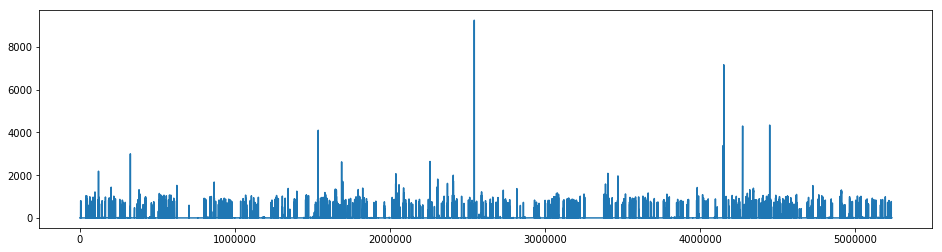

In [6]:
# plot genome coverage of entire genome

plot_depth_coverage(depth_bed)

In [7]:
# check hisD gene (hisD gene: 4723086..4724387)
# check trpB gene (trpB gene: 2749668..2750870)

hisD = pybedtools.BedTool('NZ_CP033381.1 4723086 4724387 hisD', from_string=True)
trpB = pybedtools.BedTool('NZ_CP033381.1 2749668 2750870 trpB', from_string=True)

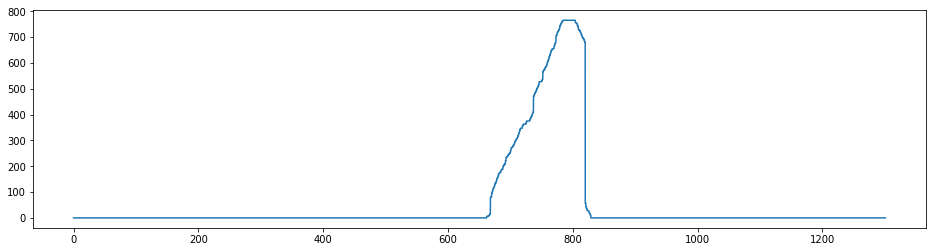

In [8]:
# get hisD coverage

hisD_coverage = depth_bed.intersect(hisD)
fig, axis = plot_depth_coverage(hisD_coverage)

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a1e2b67b8>)

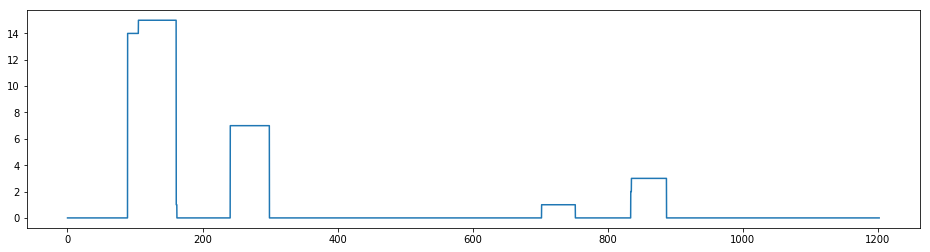

In [9]:
# get trpB coverage

trpB_coverage = depth_bed.intersect(trpB)
plot_depth_coverage(trpB_coverage)

## Visualizing sequence variants

In [10]:
# read vcf file as BedTool

variant_bed = pybedtools.BedTool('../scratchspace/8777.3.112209.CCTTAG_NZ_CP033381.1.vcf')

In [11]:
# checkout example variant

example_variant = variant_bed[2]
print(example_variant)

NZ_CP033381.1	4565	.	A	C	225.007	.	DP=260;VDB=0;SGB=-0.693147;MQSB=0.711303;MQ0F=0;AF1=1;AC1=1;DP4=0,0,248,12;MQ=49;FQ=-999	GT:PL	1:255,0



In [12]:
# look at what kinds of things I can do with a variant interval, compared to other interval objects

field_list = [method for method in dir(example_variant) if not method.startswith('_')] 
print(field_list)

['append', 'attrs', 'chrom', 'count', 'deparse_attrs', 'end', 'fields', 'file_type', 'length', 'name', 'o_amt', 'o_end', 'o_start', 'score', 'start', 'stop', 'strand']


In [13]:
# it appears I can access any stored field of information in a variant file with the 'fields' method

for field in example_variant.fields:
    print(field)

NZ_CP033381.1
4565
.
A
C
225.007
.
DP=260;VDB=0;SGB=-0.693147;MQSB=0.711303;MQ0F=0;AF1=1;AC1=1;DP4=0,0,248,12;MQ=49;FQ=-999
GT:PL
1:255,0


In [14]:
# select the hisD and trpB variants to visualize

hisD_var = variant_bed.intersect(hisD)
trpB_var = variant_bed.intersect(trpB)

In [15]:
# function to plot variants in given bedfile

def plot_variants(region, begin, end):
    """
    plot_variants() plots all of the estimated genome variants within a region of interest. The y value is a 
        p-value (back-calculated from the Phred score) estimator of the confidence of the base variation
        
    Args:
        region (pybedtools.bedtool.BedTool): a bedtool from a VCF file representing the single base variants
            along a particular genome bed
        begin (int): base coordinate of the beginning of the region of interest
        end (int): base coordinate of the end of the region of interest
    
    Returns:
        matplotlib axis of the generated coverage plot
    """
    bases = [0.0]
    p_variant = [0.0]

    for interval in region:
        start = interval.start - begin + 0.1    # offset coordinates to convert to floats
        stop = interval.stop - begin - 0.1    # and to prevent two depths at the same coordinate
        p_value = 1.0 - math.pow(10.0, float(interval[5]) * -0.1)    # calculate p-value from Phred score
        bases.extend([start - 0.1, start, stop, stop + 0.1])    # add both start and stop to the list of positions
        p_variant.extend([0.0, p_value, p_value, 0.0])    # add depths for both start and stop coordinates
    bases.append(end - begin)
    p_variant.append(0.0)
    
    fig, axis = plt.subplots(figsize=(16, 4))
    sns.lineplot(x=bases, y=p_variant, ax=axis, color='orange')
    
    return axis

/Users/stephenblaskowski/miniconda3/envs/seqalyze/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


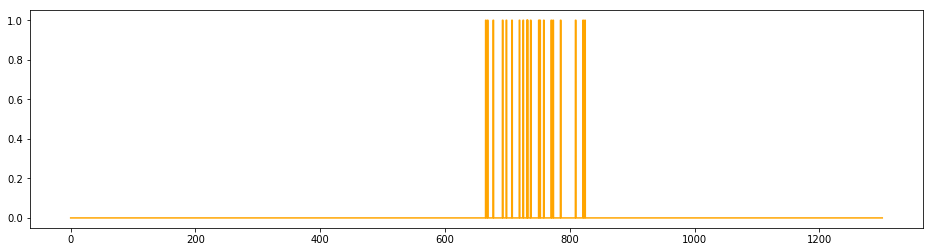

In [16]:
# Examine the hisD variants

plot_variants(hisD_var, 4723086, 4724387)

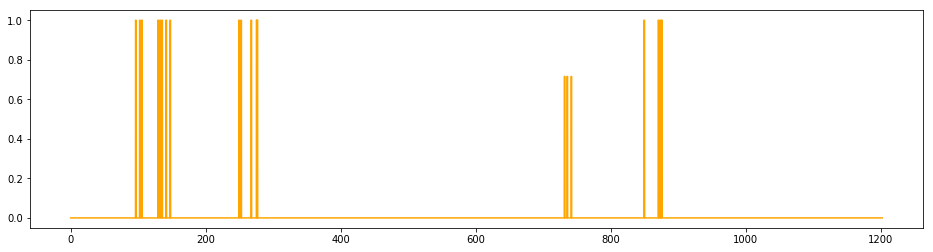

In [17]:
# examine the trpB variants

plot_variants(trpB_var, 2749668, 2750870)

# to do next: 
- overlay the two
- do this for multiple samples
    - grid view? stacked?
- multi-sample summary:
    - coverage (% of region w/ @ least x reads)
    - avg coverage depth
    - number of mutant bases
- finish running GNU parallel pipeline



In [18]:
# function to overlay variants over coverage

def coverage_variants_plot(coverage_bed, variant_bed, begin, end, axis, name=None, labels=True, legend=True):
    """
    coverage_variants_plot() returns an overlay plot with the coverage and variants within a given region.
        Note that the coverage bed and variant bed provided should both be for the same region.
        
    Args:
        coverage_bed (pybedtools.bedtool.BedTool):
        variant_bed (pybedtools.bedtool.BedTool):
        begin (int):
        end (int):
        axis (matplotlib.axis.Axis):
        region_label=None (str):
        
    Returns:
        a sns axis plot
    """
    coverage_bases = []
    coverage = []
    variant_bases = [0.0]
    p_variant = [0.0]

    for interval in coverage_bed:
        start = interval.start - begin + 0.1    # offset coordinates to convert to floats
        stop = interval.stop - begin - 0.1    # and to prevent two depths at the same coordinate
        depth = float(interval.name)
        coverage_bases.extend([start, stop])    # add both start and stop to the list of positions
        coverage.extend([depth, depth])    # add depths for both start and stop coordinates
    
    for interval in variant_bed:
        start = interval.start - begin + 0.1    # offset coordinates to convert to floats
        stop = interval.stop - begin - 0.1    # and to prevent two depths at the same coordinate
        p_value = 1.0 - math.pow(10.0, float(interval[5]) * -0.1)    # calculate p-value from Phred score
        variant_bases.extend([start - 0.1, start, stop, stop + 0.1])    # add both start and stop to the list of positions
        p_variant.extend([0.0, p_value, p_value, 0.0])    # add depths for both start and stop coordinates
    variant_bases.append(end - begin)
    p_variant.append(0.0)
    
    axis2 = axis.twinx()
    sns.lineplot(x=coverage_bases, y=coverage, ax=axis, color='blue', label='coverage', legend=False)    
    # plot coverage second, y axis on left
    sns.lineplot(x=variant_bases, y=p_variant, ax=axis2, color='orange', alpha=0.5, 
                            label='sequence\nvariants', legend=False)    
    # plot variants first, y axis on right
    axis.fill_between(x=coverage_bases, y1=coverage, color='blue', alpha=0.3)
    axis2.set_ylim([-0.05, 1.05])
    
    if name != None:
        axis.set_title(name)
    else:
        pass
    
    if labels:
        axis.set_xlabel('relative base coordinate')
        axis.set_ylabel('coverage depth\n(number of reads)')
        axis2.set_ylabel('probability of\nsequence variation')
    else:
        pass
    
    if legend:
        cov_line, cov_label = axis.get_legend_handles_labels()
        var_line, var_label = axis2.get_legend_handles_labels()
        axis.legend(cov_line + var_line, cov_label + var_label)
    else:
        pass
        
    return axis2


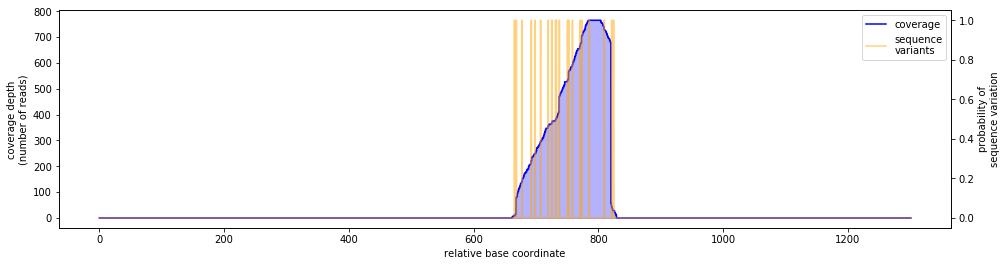

In [19]:
# run the joint plot with hisD & no title

fig, axis = plt.subplots(figsize=(16, 4))

coverage_variants_plot(hisD_coverage, hisD_var, 4723086, 4724387, axis)

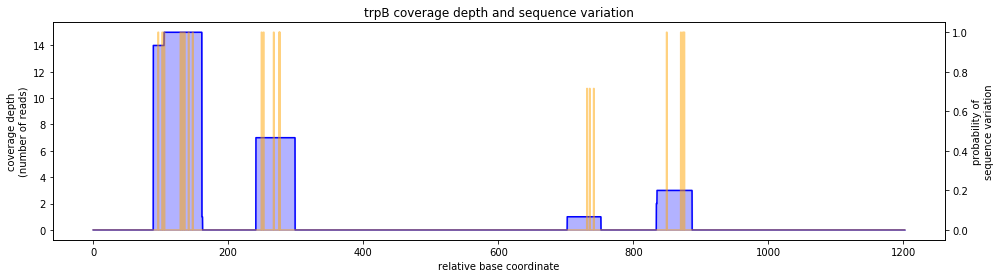

In [20]:
# run the joint plot with trpB & title

fig, axis = plt.subplots(figsize=(16, 4))

coverage_variants_plot(trpB_coverage, trpB_var, 2749668, 2750870, axis, 'trpB coverage depth and sequence variation', 
                       labels=True, legend=False)

Text(0.94, 0.5, 'probability of\nsequence variation')

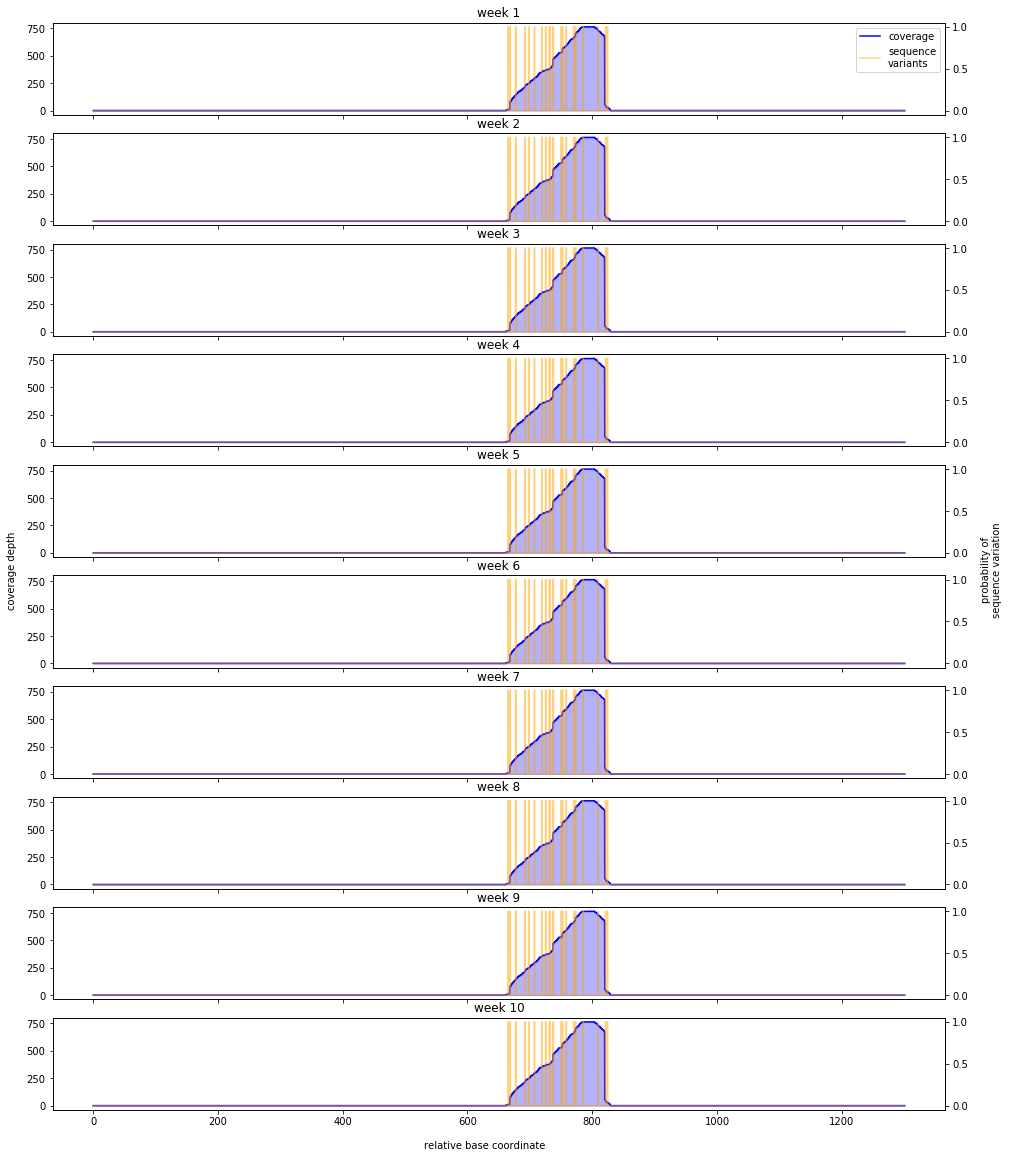

In [21]:
# plot five coverage plots with different titles

fig, axes = plt.subplots(10, 1, sharex=True, figsize=(16, 20))

counter = 1
for ax in axes:
    if counter == 1:
        legend = True
    else:
        legend = False
    
    coverage_variants_plot(hisD_coverage, hisD_var, 4723086, 4724387, ax, 'week {}'.format(counter), 
                           labels=False, legend=legend)
    ax.set_xlabel('')
    counter += 1
    
fig.text(0.5, 0.1, 'relative base coordinate', ha='center', va='center')
fig.text(0.09, 0.5, 'coverage depth', ha='center', va='center', rotation='vertical')
fig.text(0.94, 0.5, 'probability of\nsequence variation', ha='center', va='center', rotation='vertical')

In [81]:
# fig.savefig('coverage_plot.png')